# Keras starter kit [full training set, UNet]

## Setup

In [49]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2

import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from tqdm import tqdm
import cv2

# Data config
# DATA_DIR = '/kaggle/input/vesuvius-challenge-ink-detection/'
DATA_DIR = "."
BUFFER = 64  # Half-size of papyrus patches we'll use as model inputs
Z_DIM = 32  # Number of slices in the z direction. Max value is 64 - Z_START
Z_START = 16  # Offset of slices in the z direction
SHARED_HEIGHT = 4000  # Height to resize all papyrii

# (y, x)
val_location = (600, 500)
val_zone_size = (1000, 500)

# Model config
BATCH_SIZE = 64
USE_MIXED_PRECISION = False
USE_JIT_COMPILE = False

device = torch.device("cuda")
threshold = 0.25
num_workers = 2
exp = 1e-7

In [50]:
all_median = [19944., 20054., 20186., 20350., 20561., 20833., 21149., 21521.,
        21908., 22264., 22528., 22622., 22458., 21933., 21038., 19960.,
        18980., 18247., 17806., 17675., 17848., 18266., 18841., 19475.,
        20094., 20650., 21128., 21526., 21848., 22109., 22319., 22489.]

In [51]:
all_MAD = [12953., 12971., 13006., 13052., 13099., 13152., 13246., 13371.,
       13550., 13778., 14048., 14332., 14592., 14804., 14870., 14558.,
       13639., 12094., 10135.,  8519.,  7500.,  6682.,  5969.,  5350.,
        4828.,  4399.,  4056.,  3787.,  3576.,  3408.,  3272.,  3160.]

In [52]:
def resize(img):
    current_height, current_width = img.shape    
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    # (W, H)の順で渡すが結果は(H, W)になっている
    img = cv2.resize(img, new_size)
    return img

def load_mask(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/mask.png", 0) // 255
    img = resize(img)    
    return img


def load_labels(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/inklabels.png", 0) // 255
    img = resize(img)
    return img


In [53]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = cv2.imread(filename, -1)
        img = resize(img)
        z_slices.append(img)
    return np.stack(z_slices, axis=-1)

In [54]:
def sample_random_location(shape):
    random_train_x = np.random.randint(low=BUFFER, high=shape[1] - BUFFER - 1, size=())
    random_train_y = np.random.randint(low=BUFFER, high=shape[0] - BUFFER - 1, size=())
    random_train_location = np.stack([random_train_y, random_train_x], axis=-1)
    return random_train_location


def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]] > 0

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[1]
    y = location[0]
    x_match = val_location[1] - BUFFER <= x <= val_location[1] + val_zone_size[1] + BUFFER
    y_match = val_location[0] - BUFFER <= y <= val_location[0] + val_zone_size[0] + BUFFER
    return x_match and y_match


In [55]:
printed = False

def extract_subvolume(location, volume):
    global printed
    # print(np.unique(volume, return_counts=True, return_index=True))
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :].astype(np.float32)
    # print("subvolume[:, :, 0]", subvolume[:, :, 0])
    median = np.full_like(subvolume, all_median).astype(np.float32)
    MAD = np.full_like(subvolume, all_MAD).astype(np.float32)
    # mean = np.mean(subvolume, axis=2)
    # mean = np.stack([mean for i in range(Z_DIM)], axis=2) + exp
    # MAD = median_abs_deviation(subvolume, axis=2)
    # print("MAD", MAD[0, 0, :])
    # print("mean", mean)
    # print("median", median[0, 0, :])
    
    subvolume = (subvolume - median) / MAD
    
    if not printed:
        print("subvolume after taking care of median and MAD", subvolume)
        printed = True
    
    return subvolume

In [56]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

class SubvolumeDataset(Dataset):
    def __init__(self, locations, volume, labels, buffer, is_train: bool, return_location: bool = False):
        self.locations = locations
        self.volume = volume
        self.labels = labels        
        self.buffer = buffer
        self.is_train = is_train
        self.return_location = return_location

    def __len__(self):
        return len(self.locations)

    def __getitem__(self, idx):
        label = None
        location = np.array(self.locations[idx])
        y, x = location[0], location[1]

        subvolume = extract_subvolume(location, self.volume)        
        # print("subvolume", subvolume)
        # print("labels", labels)
        # subvolume = subvolume.numpy()
        subvolume = subvolume
        
        if self.labels is not None:
            label = self.labels[y - self.buffer:y + self.buffer, x - self.buffer:x + self.buffer]
            # print("label", label)
            # n_category = 2
            # label = np.eye(n_category)[label]
            label = np.stack([label], axis=-1)
            # label = label.numpy()
            # print("label.shape", label.shape
        
        if self.is_train and label is not None:            
            
            # print("label", label.dtype)
            # print("subvolume in dataset (before aug)", subvolume)            
            # performed = A.Compose([            
            #     A.ToFloat(max_value=possible_max_input),
            #     # A.RandomBrightnessContrast(),
            #     # A.HorizontalFlip(),
            #     # A.VerticalFlip(),  
            #     # A.Normalize(
            #     #     mean=[mean],
            #     #     std=[std],
            #     # ),
            #     A.FromFloat(max_value=possible_max_input),
            # ])(image=subvolume, mask=label)
            # subvolume = performed["image"]            
            # label = performed["mask"]
            # print("subvolume in dataset (after aug)", subvolume)
            # print("label", label.dtype)
            # print("subvolume", subvolume.dtype)
            # →C, H, W
            subvolume = torch.from_numpy(subvolume.transpose(2, 0, 1).astype(np.float64))
            # print(performed)
            # print(subvolume.shape, label.shape)
            # H, W, C → C, H, W
            label = torch.from_numpy(label.transpose(2, 0, 1).astype(np.uint8)) 
        else:            
            # performed = A.Compose([  
            #     A.ToFloat(max_value=possible_max_input),                
            #     # A.Normalize(
            #     #     mean=[mean],
            #     #     std=[std],
            #     # ),
            #     A.FromFloat(max_value=possible_max_input),
            # ])(image=subvolume)
            # subvolume = performed["image"]
            subvolume = torch.from_numpy(subvolume.transpose(2, 0, 1).astype(np.float64))
            if label is not None:
                label = torch.from_numpy(label.transpose(2, 0, 1).astype(np.uint8)) 
        if self.return_location:
            return subvolume, location
        return subvolume, label        

In [57]:

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(                
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )

        def transpose_conv_block(in_channels, out_channels):
            return nn.Sequential(                
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )

        self.encoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels if i == 2 else 64 * 2**(i - 1), 64 * 2**i, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(64 * 2**i),
                nn.ReLU(),
                nn.Conv2d(64 * 2**i, 64 * 2**i, kernel_size=3, padding=1),
                nn.BatchNorm2d(64 * 2**i),
                nn.ReLU(),
            )
            for i in range(2, 4)
        ])


        self.middle = nn.Sequential(
            conv_block(512, 512),
            conv_block(512, 512),
        )
        
        self.decoder = nn.ModuleList([
            nn.Sequential(
                transpose_conv_block(2 ** (i + 7), 2 ** (i + 6)),
                transpose_conv_block(2 ** (i + 6), 2 ** (i + 5)),
                nn.Upsample(scale_factor=2, mode="nearest"),
            )
            for i in range(3, 1, -1)
        ])
        self.final_decoder = nn.Sequential(
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
        )
        self.activation = nn.Identity()

    def forward(self, x):
        # print("input:", x)
        skip_connections = []
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)

        x = self.middle(x)
        
        # print("encoder ok", x)
        for i, layer in enumerate(self.decoder):            
            # print(f"decoder will {i}: ok", x.shape)
            x = torch.cat([x, skip_connections[-i-1]], dim=1)  # Concatenate along channel dimension
            # print(f"decoder with skip connection {i}: ok", x.shape)            
            x = layer(x)            
            # print(f"decoder {i}: ok", x)
        # print("decoder ok")
        x = self.final_decoder(x)
        x = self.activation(x)
        # print("final out", x)
        return x

In [58]:
device = torch.device("cuda")

In [59]:
model = UNet(Z_DIM, 2)
model = nn.DataParallel(model)
# model.load_state_dict(torch.load(f"/kaggle/input/ink-detection/model.pt"))
model.load_state_dict(torch.load("model.pt"))
model = model.to(device)

## Load up the training data

In [60]:

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

def compute_predictions_map(split, index):
    
    print(f"Load data for {split}/{index}")

    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)    

    test_locations = []
    stride = BUFFER // 2
    for y in range(BUFFER, test_volume.shape[0] - BUFFER, stride):
        for x in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
            test_locations.append((y, x))

    print(f"{len(test_locations)} test locations (before filtering by mask)")

    # filter locations inside the mask
    test_locations = [loc for loc in test_locations if is_in_masked_zone(loc, test_mask)]
    
    print(f"{len(test_locations)} test locations (after filtering by mask)")

    test_ds = SubvolumeDataset(test_locations, test_volume, None, BUFFER, is_train=False, return_location=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=num_workers)

    # shape: (X, Y, C)
    predictions_map = np.zeros_like(test_volume[:, :, 0]).transpose((1, 0))[:, :, np.newaxis].astype(np.float64)
    
    print("test_volume.shape", test_volume.shape)
    print("predictions_map.shape", predictions_map.shape)

    print(f"Compute predictions")

    model.eval()  # set model to evaluation mode
    with torch.no_grad():    
        for patch_batch, loc_batch in tqdm(test_loader):
            loc_batch = loc_batch.to(device).long()
            patch_batch = patch_batch.to(device).float()
            predictions = model(patch_batch)
            # print("predictions", predictions)
            predictions = nn.Softmax(dim=1)(predictions)
            predictions: torch.Tensor = predictions[:, 1, :, :].unsqueeze(dim=1)
            # print("Softmaxed predictions where conf is gt threshold", predictions[predictions.gt(threshold)])
            # →(BATCH, W, H, C)
            predictions = torch.permute(predictions, (0, 3, 2, 1))
            predictions = predictions.cpu().numpy()  # move predictions to cpu and convert to numpy
            for (y, x), pred in zip(loc_batch, predictions):
                # print("index: ", index ,"x, y, pred", x.item(), y.item(), pred[BUFFER, BUFFER, :].item(), file=open('log.out', 'a'))
                predictions_map[
                    x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :
                ][pred > threshold] = 1
    print("predictions_map", predictions_map, file=open("predictions_map", "w"))
    return predictions_map


In [61]:
from skimage.transform import resize as resize_ski
import pathlib

In [62]:
def rle(predictions_map, threshold):
    flat_img = (np.where(predictions_map.flatten() >= threshold, 1, 0)).astype(np.uint8)
    
    # Add padding at the beginning and end
    flat_img = np.pad(flat_img, pad_width=1, mode='constant', constant_values=0)

    starts = np.where((flat_img[:-1] == 0) & (flat_img[1:] == 1))[0]
    ends = np.where((flat_img[:-1] == 1) & (flat_img[1:] == 0))[0]

    lengths = ends - starts
    
    print(lengths.shape)

    return " ".join(map(str, np.c_[starts, lengths].flatten()))


In [63]:
def update_submission(predictions_map, index):
    rle_ = rle(predictions_map, threshold=threshold)
    print(f"{index}," + rle_, file=open('submission.csv', 'a'))

Load data for train/1


32it [00:03, 10.23it/s]


11253 test locations (before filtering by mask)
6750 test locations (after filtering by mask)
test_volume.shape (4000, 3094, 32)
predictions_map.shape (3094, 4000, 1)
Compute predictions


  0%|          | 0/106 [00:00<?, ?it/s]

subvolume after taking care of median and MAD [[[-1.5397205  -1.5460643  -1.5520529  ... -6.4873824  -6.8212104
   -7.116772  ]
  [-1.5397205  -1.5460643  -1.5520529  ... -6.4873824  -6.8212104
   -7.116772  ]
  [-1.5397205  -1.5460643  -1.5520529  ... -6.4873824  -6.8212104
   -7.116772  ]
  ...
  [-1.5397205  -1.5460643  -1.5520529  ... -6.4873824  -6.8212104
   -7.116772  ]
  [-1.5397205  -1.5460643  -1.5520529  ... -6.4873824  -6.8212104
   -7.116772  ]
  [-1.5397205  -1.5460643  -1.5520529  ... -6.4873824  -6.8212104
   -7.116772  ]]

 [[-1.5397205  -1.5460643  -1.5520529  ... -6.4873824  -6.8212104
   -7.116772  ]
  [-1.5397205  -1.5460643  -1.5520529  ... -6.4873824  -6.8212104
   -7.116772  ]
  [-1.5397205  -1.5460643  -1.5520529  ... -6.4873824  -6.8212104
   -7.116772  ]
  ...
  [-1.5397205  -1.5460643  -1.5520529  ... -6.4873824  -6.8212104
   -7.116772  ]
  [-1.5397205  -1.5460643  -1.5520529  ... -6.4873824  -6.8212104
   -7.116772  ]
  [-1.5397205  -1.5460643  -1.5520529 

100%|██████████| 106/106 [00:14<00:00,  7.53it/s]


original predictions_map size (8181, 6330)
(0,)
Load data for train/2


32it [00:07,  4.24it/s]


9317 test locations (before filtering by mask)
6841 test locations (after filtering by mask)
test_volume.shape (4000, 2563, 32)
predictions_map.shape (2563, 4000, 1)
Compute predictions


  0%|          | 0/107 [00:00<?, ?it/s]

subvolume after taking care of median and MAD [[[-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  [-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  [-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  ...
  [-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  [-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  [-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]]

 [[-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  [-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  [-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  ...
  [-1.5397205e+00 -1.5460643e+0

100%|██████████| 107/107 [00:12<00:00,  8.55it/s]


original predictions_map size (14830, 9506)
(0,)
Load data for train/3


32it [00:02, 15.17it/s]


10043 test locations (before filtering by mask)
6731 test locations (after filtering by mask)
test_volume.shape (4000, 2760, 32)
predictions_map.shape (2760, 4000, 1)
Compute predictions


  0%|          | 0/106 [00:00<?, ?it/s]

subvolume after taking care of median and MAD [[[-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  [-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  [-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  ...
  [-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  [-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  [-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]]

 [[-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  [-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  [-1.5397205e+00 -1.5460643e+00 -1.5520529e+00 ... -6.4873824e+00
   -6.8212104e+00 -7.1167722e+00]
  ...
  [-1.5397205e+00 -1.5460643e+0

100%|██████████| 106/106 [00:13<00:00,  8.00it/s]


original predictions_map size (7606, 5249)
(0,)


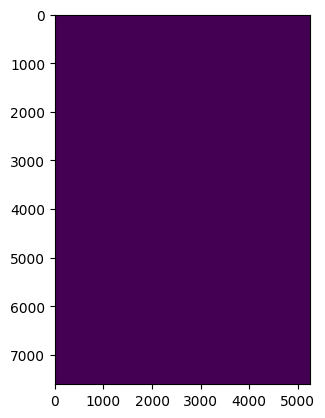

In [64]:
print("Id,Predicted", file=open('submission.csv', 'w'))
folder = pathlib.Path(DATA_DIR) / "train"
for p in list(folder.iterdir()):
    index = p.stem
    predictions_map = compute_predictions_map(split="train", index=index)
    original_size = cv2.imread(DATA_DIR + f"/train/{index}/mask.png", 0).shape[:2]
    # W, H, C → H, W, C
    predictions_map = predictions_map.transpose((1, 0, 2))    
    predictions_map = resize_ski(predictions_map, (original_size[0], original_size[1], 1)).squeeze(axis=-1)    
    print("original predictions_map size", predictions_map.shape)    
    # H, W → W, H
    update_submission(predictions_map, index)
    plt.imshow(predictions_map)